<p style="background:#045c6b; color:white; font-size: 2.1em; text-align:center"> 
    <br><br><b> Travel Insurance Prediction</b><br><br><br>
</p>

<p style="text-align: right;">Module 3: Machine Learning<br>
Sprint 1: Supervised Machine Learning Fundamentals<br>
Author : Renato Mariano</p>

<h1 style="color:#045c6b">Introduction </h1>

This project will utilize a publicly available dataset from Kaggle. The dataset in question is the Travel Insurance Prediction Data, which can be found on https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data.

A _Tour & Travels Company_ is offering travel insurance package to their customers and a you are the responsible data scientist to provide the company with answers and a prediction model.

The data is provided for almost 2000 of its previous customers (The time of when the data was collected is not preciselly described by the dataset's author).

<h2 style="color:#045c6b">Objectives </h2>

The objective of this notebook is to guide you through an analysis of the dataset and to **create a model that predicts clients who would possibily want to buy the travel insurance**.

This predictive model can be a **valuable asset for travel insurance companies and their marketing teams** to improve **customer retention and company revenue**. 

<h2 style="color:#045c6b">Proposed Questions </h2>

The following questions will be answered during the analysis.

- What proportion of the clients bought travel insurances.
- How are the features distrubuted?
- What are the most important features for the decision of buying a travel insurance?

<h1 style="color:#045c6b">Library Imports and Notebook Setup</h1>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xmltodict

from statsmodels.stats.proportion import proportions_ztest

from suplement_functions import (clear_barplot, create_countplot)

In [2]:
# Modeling Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

import pydotplus
from IPython.display import Image

In [3]:
# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)       # control the amount of output digits

from IPython.core.display import HTML                             # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#045c6b">Exploratory Data Analysis</h1>

<h2 style="color:#045c6b">Initial Exploration</h2>

Let's start by reading our dataset and initially exploring its characteristics.

In [4]:
travel_insur = pd.read_csv("data/TravelInsurancePrediction.csv", index_col=0)
travel_insur.head(5)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Explanation about some columns (given by the dataset's authour):

**AnnualIncome**- customer's annual income in Indian Rupees (Rounded to nearest 50K)

**FrequentFlyer**- customer's history of booking air tickets on at least 4 different instances in the last 2 years(2017-2019).

**TravelInsurance**- indicates whether the customer purchased a travel insurance package during an introductory offering held in the year 2019.

In [5]:
print(f"The shape of the data is: {travel_insur.shape}\n\n")
print(travel_insur.info())

The shape of the data is: (1987, 9)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB
None


Our initial exploration shows that the **dataframe is composed by 9 features and does not present any null values**.

Some of the **features** are pure **categories** and, all the other are integer values that can also be classified as categories.

Let's take a look at the **dataset description** and at what a **median custumer** looks like.

In [6]:
travel_insur.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000,1987.000,1987.000,1987.000,1987.000
mean,29.650,932762.959,4.753,0.278,0.357
std,2.913,376855.685,1.610,0.448,0.479
min,25.000,300000.000,2.000,0.000,0.000
25%,28.000,600000.000,4.000,0.000,0.000
50%,29.000,900000.000,5.000,0.000,0.000
75%,32.000,1250000.000,6.000,1.000,1.000
max,35.000,1800000.000,9.000,1.000,1.000


In [7]:
travel_insur.describe(include=["object"]).T

,count,unique,top,freq
Employment Type,1987,2,Private Sector/Self Employed,1417
GraduateOrNot,1987,2,Yes,1692
FrequentFlyer,1987,2,No,1570
EverTravelledAbroad,1987,2,No,1607


**A median customer** (based on the median value for each feature) for this enterprise would have the following characteristics:
 - 29 years old
 - 900k rupees annual income
 - Private Sector/Self Employed
 - Graduated
 - 5 family members
 - no travel insurance
 - no chronic diseases
 - not a frequent flyer
 - never travelled abroad

<h2 style="color:#045c6b">Duplicates</h2>

Let's take a look at the **duplicates**

In [8]:
print(f"The amount of duplicated rows is: {travel_insur[travel_insur.duplicated()].shape[0]}\n")

travel_insur[travel_insur.duplicated()].head()

The amount of duplicated rows is: 738



,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
69,31,Government Sector,No,300000,4,0,No,No,0
103,26,Private Sector/Self Employed,Yes,1400000,5,0,No,Yes,1
117,31,Government Sector,Yes,400000,5,0,No,No,0
148,25,Private Sector/Self Employed,Yes,1400000,4,0,No,Yes,1
164,28,Government Sector,Yes,300000,6,0,No,No,0


**Here no duplicated is expected to represent the same client**, as this dataset present only 9 features many of the clients present similar/equal information. 

<h2 style="color:#045c6b">Distribution of Numerical Values</h2>

Next, let's take a look at **distribution of the numerical features** (excluding all the binaries) and at their **skewness**.

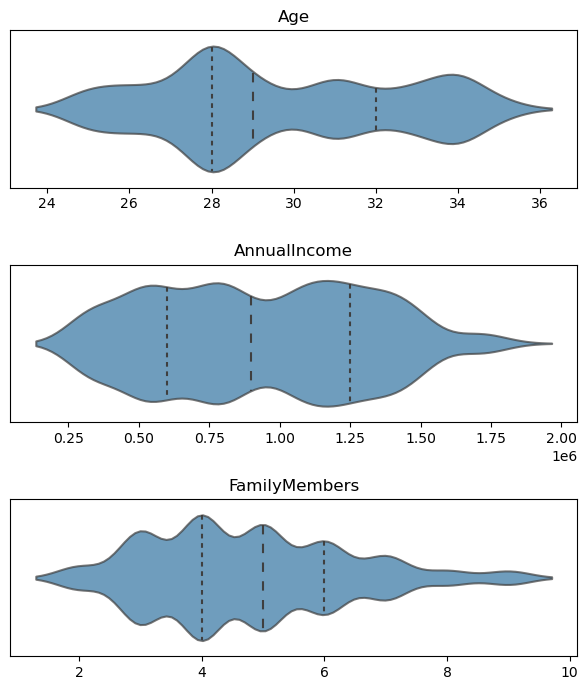

In [9]:
num_cols = ["Age", "AnnualIncome", "FamilyMembers"]

# Violin plots
fig, axes = plt.subplots(3, 1, figsize=(6, 7))

for i, col in enumerate(num_cols):
    sns.violinplot(data=travel_insur[col], ax=axes[i], inner='quartile', orient='h')

    axes[i].set(title=col, ylabel="")
    axes[i].set_yticklabels([])
    axes[i].tick_params(axis="y", which="both", length=0)
    plt.setp(axes[i].collections, alpha=0.7)

plt.tight_layout()


In [10]:
print("Skewness of the parameters\n")
for col in num_cols:
    print(f"{col} : {travel_insur[col].skew():.3f}")

Skewness of the parameters

Age : 0.240
AnnualIncome : 0.078
FamilyMembers : 0.561


The skewness of the features highlight that **no outliers** are presented here.

These violinplots provide **good insights about the distribution** of these features. We can grap the profile of ages, annual income and quantity of family members of their clients. 

**None of the this features are normally distributed** (which is also expected for integer values).

<h2 style="color:#045c6b">Travel Insurance Buyers</h2>

What proportion of the companies' customers actually acquired a travel insurance in 2019?

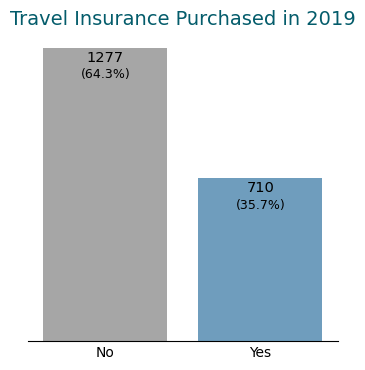

In [11]:
# Find percentages 
percentage = round(
    100
    * travel_insur["TravelInsurance"].value_counts()
    / sum(travel_insur["TravelInsurance"].value_counts()),
    1,
).tolist()
percentage = [f"({x}%)" for x in percentage]

# Generate the plot
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    x=travel_insur["TravelInsurance"].value_counts().index,
    y=travel_insur["TravelInsurance"].value_counts(),
    ax=ax,
    palette=["grey", "tab:blue"],
    alpha=0.7,
)

ax.set_xticklabels(['No', 'Yes'])

clear_barplot(
    ax,
    percentage,
    plot_title="Travel Insurance Purchased in 2019",
    pad_top=-12,
    pad_bottom=-24,
)

We see that about **36% of customers bought a travel insurance** in 2019.

How does this distribution look like throughout the different features?

In [12]:
cols = [
    "Employment Type",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "GraduateOrNot",
]

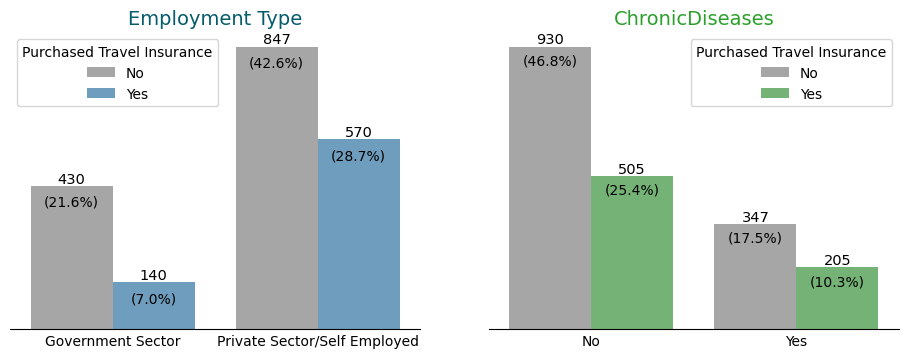

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# Employment Type
create_countplot(df=travel_insur, ax=axes[0], col=cols[0])
clear_barplot(axes[0], plot_title=cols[0], pad_top=0, legend_visibility=True)

#ChronicDiseases
create_countplot(df=travel_insur, ax=axes[1], col=cols[1], palette=["grey", "tab:green"])
clear_barplot(axes[1], plot_title=cols[1], pad_top=0, legend_visibility=True, title_color="tab:green")
axes[1].set_xticklabels(['No', 'Yes'])


axes[1].legend(["No", "Yes"], title="Purchased Travel Insurance")

plt.tight_layout(pad=4.0)

In [14]:
freq_data = travel_insur.groupby([cols[0], "TravelInsurance"]).size()

print(f"Government Sector, bought insurance: {freq_data.iloc[1]/(freq_data.iloc[0] + freq_data.iloc[1])*100:.1f}%")
print(f"Private Sector, bought insurance: {freq_data.iloc[3]/(freq_data.iloc[3] + freq_data.iloc[2])*100:.1f}%\n")

freq_data = travel_insur.groupby([cols[1], "TravelInsurance"]).size()

print(f"Doesn't have Chronic Disease, bought insurance: {freq_data.iloc[1]/(freq_data.iloc[0] + freq_data.iloc[1])*100:.1f}%")
print(f"Has Chronic Disease, bought insurance: {freq_data.iloc[3]/(freq_data.iloc[3] + freq_data.iloc[2])*100:.1f}%")

Government Sector, bought insurance: 24.6%
Private Sector, bought insurance: 40.2%

Doesn't have Chronic Disease, bought insurance: 35.2%
Has Chronic Disease, bought insurance: 37.1%


A **greater proportion of Employees in the Private Sector**/Self Employed obtained health insurance **40%** against 24% in the Governmental Sector.

**Having a Chronic Diseases does not seem to affect the buying of insurances**.

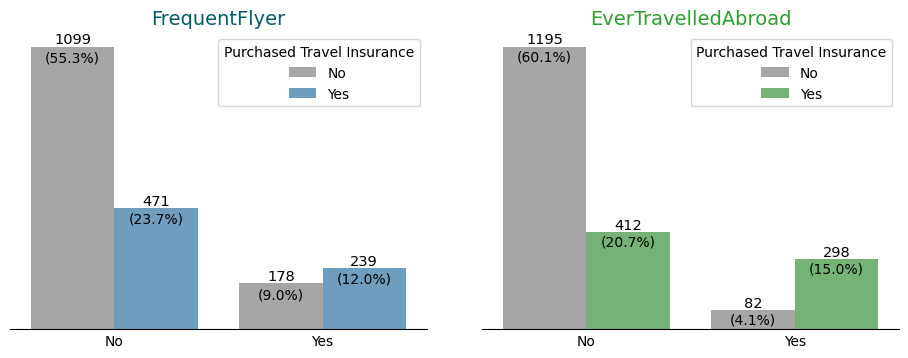

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# Frequent Flyer
create_countplot(df=travel_insur, ax=axes[0], col=cols[2])
clear_barplot(axes[0], plot_title=cols[2], pad_top=0, legend_visibility=True)

# Travelled Abroad
create_countplot(df=travel_insur, ax=axes[1], col=cols[3], palette=["grey", "tab:green"])
clear_barplot(axes[1], plot_title=cols[3], pad_top=0, legend_visibility=True, title_color="tab:green")

plt.tight_layout(pad=4.0)

In [16]:
freq_data = travel_insur.groupby([cols[2], "TravelInsurance"]).size()

print(f"Not a frequent flyer, bought insurance: {freq_data.iloc[1]/(freq_data.iloc[0] + freq_data.iloc[1])*100:.1f}%")
print(f"Frequent flyer, bought insurance: {freq_data.iloc[3]/(freq_data.iloc[3] + freq_data.iloc[2])*100:.1f}%\n")


freq_data = travel_insur.groupby([cols[3], "TravelInsurance"]).size()

print(f"Didn't travel abroad, bought insurance: {freq_data.iloc[1]/(freq_data.iloc[0] + freq_data.iloc[1])*100:.1f}%")
print(f"Travelled abroad, bought insurance: {freq_data.iloc[3]/(freq_data.iloc[3] + freq_data.iloc[2])*100:.1f}%")

Not a frequent flyer, bought insurance: 30.0%
Frequent flyer, bought insurance: 57.3%

Didn't travel abroad, bought insurance: 25.6%
Travelled abroad, bought insurance: 78.4%


The proportion of **Frequent Flyers who acquired travel insurances surpassed the ones who did not** buy (57%). **The same** was seen for customers with **experience abroad** (78%).

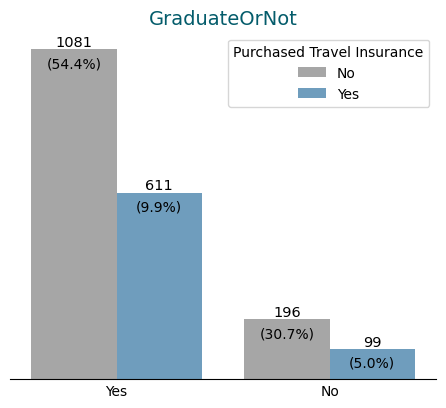

In [17]:
fig, axes = plt.subplots(figsize=(5.5, 4.5))

percentage = round(
        100
        * travel_insur.groupby([cols[4], "TravelInsurance"]).size()
        / sum(travel_insur.groupby([cols[4], "TravelInsurance"]).size()),
        1,
    ).tolist()
percentage = [f"({percentage[i]}%)" for i in [2, 3, 0, 1]]

# Graduated or not
create_countplot(df=travel_insur, ax=axes, col=cols[4], percent=percentage)
clear_barplot(axes, plot_title=cols[4], pad_top=0, legend_visibility=True)

In [18]:
freq_data = travel_insur.groupby([cols[4], "TravelInsurance"]).size()

print(f"Not graduated, bought insurance: {freq_data.iloc[1]/(freq_data.iloc[0] + freq_data.iloc[1])*100:.1f}%")
print(f"Graduated, bought insurance: {freq_data.iloc[3]/(freq_data.iloc[3] + freq_data.iloc[2])*100:.1f}%")

Not graduated, bought insurance: 33.6%
Graduated, bought insurance: 36.1%


Most of the clients are graduated, **the proportion of insurance buyers is however very similar in both groups**.

<h2 style="color:#045c6b">Age, Income and Family Members correlations</h2>

Let's plot the **Travel Insurance feature against the Annual Income, Age and Family Members**. A scatterplot between these features might provide some insight.

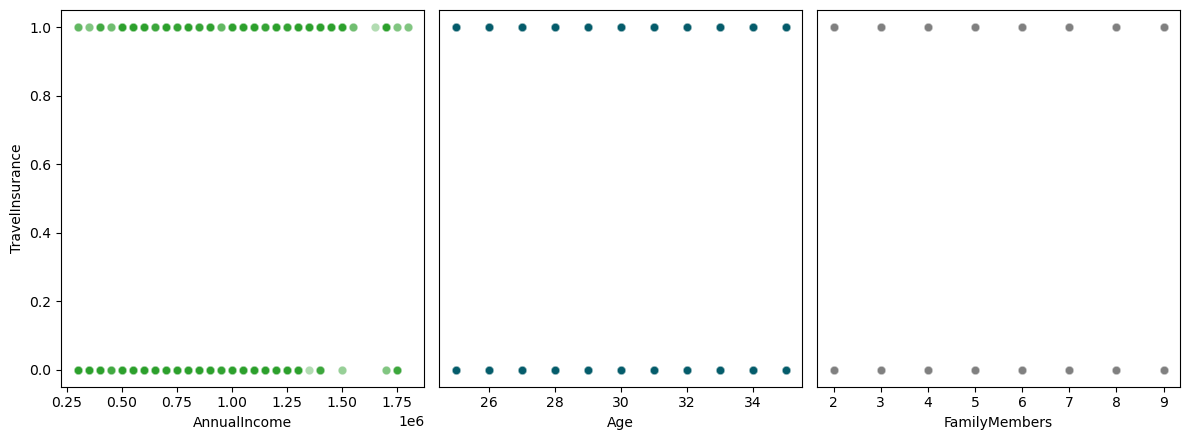

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

sns.scatterplot(data=travel_insur, y="TravelInsurance", x="AnnualIncome", ax=axes[0], color="tab:green", alpha=0.2)
sns.scatterplot(data=travel_insur, y="TravelInsurance", x="Age", ax=axes[1], color="#045c6b", alpha=0.2);
sns.scatterplot(data=travel_insur, y="TravelInsurance", x="FamilyMembers", ax=axes[2], color="grey", alpha=0.2);

axes[1].tick_params(left = False)
axes[2].tick_params(left = False)

plt.tight_layout()

The scatterplot bellow, shows a tendency of a custumer with higher annual income to buy a travel insurance.

The Age and Family members however do not provide any insight.

<h2 style="color:#045c6b">Annual Income per Family Members</h2>

To further explore relationships in the dataset, a new feature was created from the division of the customer's annual income and their family's size.

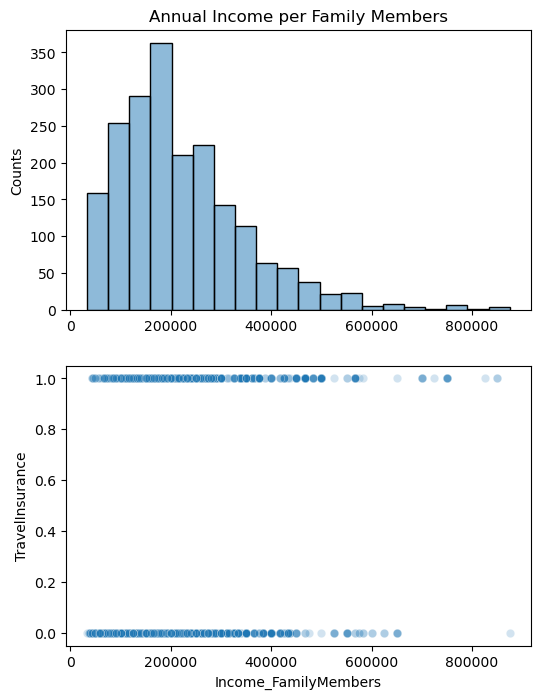

In [20]:
travel_insur["Income_FamilyMembers"] = travel_insur["AnnualIncome"] / travel_insur["FamilyMembers"]

fig, axes = plt.subplots(2, 1,figsize=(6, 8))

sns.histplot(x=travel_insur["Income_FamilyMembers"], ax=axes[0], bins=20, alpha=0.5)
axes[0].set(title="Annual Income per Family Members", ylabel="Counts", xlabel="");

sns.scatterplot(data=travel_insur, y="TravelInsurance", x="Income_FamilyMembers", ax=axes[1], alpha=0.2);

Some outliers can be seen for this feature. Furthermore, through the scatterplot we can see that some of these outliers customers (with very high salary per family member) make the choice of buying insurances.

<h1 style="color:#045c6b">Modeling </h1>

<h2 style="color:#045c6b">Features Transformation

Our analysis of the distribution of travel insurance buyers showed that the proportion of buyers was not very different amongst **graduated or not**, and amongst **bearers of chronic deseases or not**. Based on this we will **drop this two features**.

We will also drop the engineered feature ("Income_FamilyMembers") and use it only in the choosen model to see if improvements are presented.

**The other binary features** will be transformed in different columns as **One Hot Encoder**.

In [21]:
# Drop Columns
travel_insur_clean = travel_insur.drop(["GraduateOrNot", "ChronicDiseases", "Income_FamilyMembers"], axis=1)

# Encoder of features
features = ["Employment Type", "FrequentFlyer", "EverTravelledAbroad"]
one_hot_encoded_df = pd.get_dummies(travel_insur_clean[features])

# Merge and remove original features
encoded_travel_insur_clean = pd.concat(
    [travel_insur_clean, one_hot_encoded_df], axis=1
).drop(features, axis=1)

encoded_travel_insur_clean.head(2)

,Age,AnnualIncome,FamilyMembers,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,31,400000,6,0,1,0,1,0,1,0
1,31,1250000,7,0,0,1,1,0,1,0


<h2 style="color:#045c6b">Train Test Split

We start the modelling section **separating the dependent feature from the others**.

Due to our dataset size (less than 2.000 custumers), we will perform cross validation during the choice of hyperparameters in the training dataset (no separated validation process).

To separate our dataset we are goign to call train_test_split, to split data into **two sets: _a._ training (70%); and _b._ testing (30%)**.

In [22]:
# Separate dependent variable
X = encoded_travel_insur_clean.drop('TravelInsurance', axis=1)
y = encoded_travel_insur_clean['TravelInsurance']

# Separate train, validation and test data
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=99)

Some of the models tries in this section work better when all of the independent variables are in the same scale, i.e. Support Vector Machine. The scaling is performed next.

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

Our goal is to obtain the maximum number of customers who would potentially buy travel insurances. In this sense, we want the maximum recall score for the class 1 (buy travel insurance).

<h2 style="color:#045c6b">k-Nearest Neighbors Classifier (KNN)</h2>

This KNN will be used as our **baseline model**. 

Some of its limitations are: 
- Can be sensitive to irrelevant features, noisy data, and the choice of distance metric. 
- Computationally expensive for large datasets (calculates distances between all data points).

As we have integer data, it makes sense to use a Manhattan distance measure (p=1). Let's observe this in our grid search.

In [24]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

# Create GridSearchCV instance with 5 folds
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:",grid_search.best_params_)
print(f"Best Recall: {grid_search.best_score_:.3f}")

knn_best = grid_search.best_estimator_

Best Parameters: {'n_neighbors': 3, 'p': 2}
Best Recall: 0.584


The set of parameters, that provided the best average recall amongst the validation of all folds was by 3 n_neighbors with Manhattan distance.

In [25]:
# Evaluate the training
yhat_train = knn_best.predict(X_train_scaled)
report = classification_report(y_train, yhat_train, target_names=["No", "Yes"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          No       0.85      0.92      0.88       890
         Yes       0.83      0.72      0.77       500

    accuracy                           0.85      1390
   macro avg       0.84      0.82      0.83      1390
weighted avg       0.84      0.85      0.84      1390



On the whole training set (without folds), our model baseline model presents an accuracy of 85% and recall of 72% for the interest.

Let's explore these results in a confusion matrix.

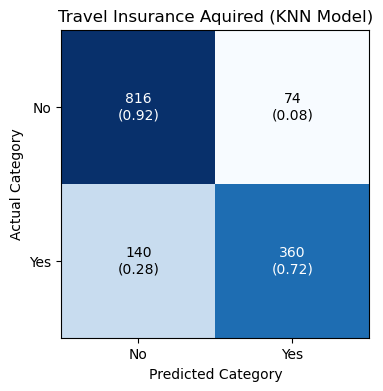

In [26]:
cm = metrics.confusion_matrix(y_train, yhat_train)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                figsize=(4, 4))

plt.xticks(np.arange(2), ["No", "Yes"])
plt.yticks(np.arange(2), ["No", "Yes"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Travel Insurance Aquired (KNN Model)",);

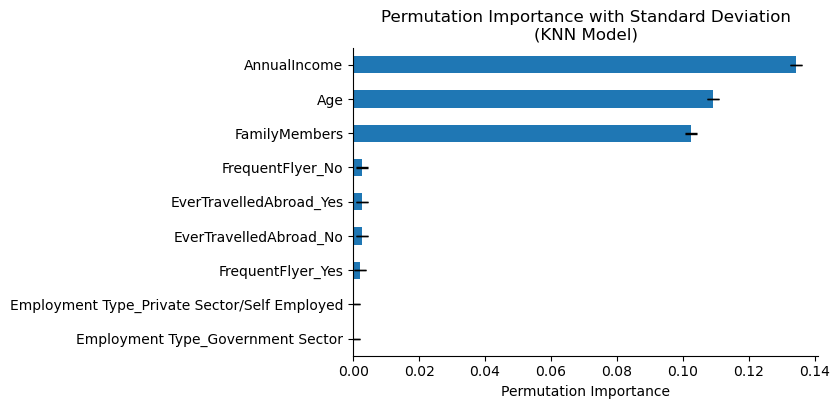

In [27]:
result = permutation_importance(knn_best, X_train_scaled, y_train, n_repeats=50, random_state=99)

feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)


ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="tab:blue",
    figsize=(6, 4),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation\n(KNN Model)",
)
ax.legend([], frameon=False);

<h2 style="color:#045c6b">Linear Logistic Regression </h2>

Due to the **nature of our dependent variable** (binary values, our first model try is with a linear logistic regression.

Hyperparameter C - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger generalization.

In [28]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
}

logreg = LogisticRegression()

# Create GridSearchCV instance with 5 folds
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:",grid_search.best_params_)
print(f"Best Recall: {grid_search.best_score_:.3f}")

logreg_best = grid_search.best_estimator_

Best Parameters: {'C': 10}
Best Recall: 0.484


In [29]:
# Evaluate the training
yhat_train = logreg_best.predict(X_train_scaled)
report = classification_report(y_train, yhat_train, target_names=["No", "Yes"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          No       0.76      0.92      0.84       890
         Yes       0.78      0.49      0.60       500

    accuracy                           0.77      1390
   macro avg       0.77      0.71      0.72      1390
weighted avg       0.77      0.77      0.75      1390



The results by the logistic regression seem are much lower for our variable of interest (recall yes class), about 49%.

There is a tendency for this model to be better at describing values of clients who did not buy travel insurances (92%)

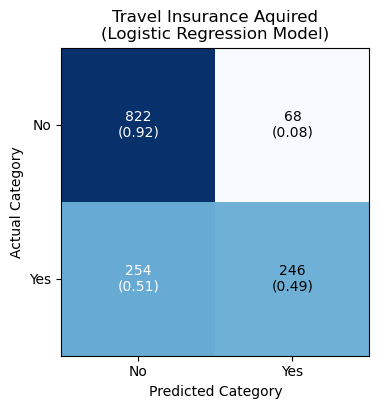

In [30]:
cm = metrics.confusion_matrix(y_train, yhat_train)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                figsize=(4, 4))

plt.xticks(np.arange(2), ["No", "Yes"])
plt.yticks(np.arange(2), ["No", "Yes"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Travel Insurance Aquired\n(Logistic Regression Model)",);

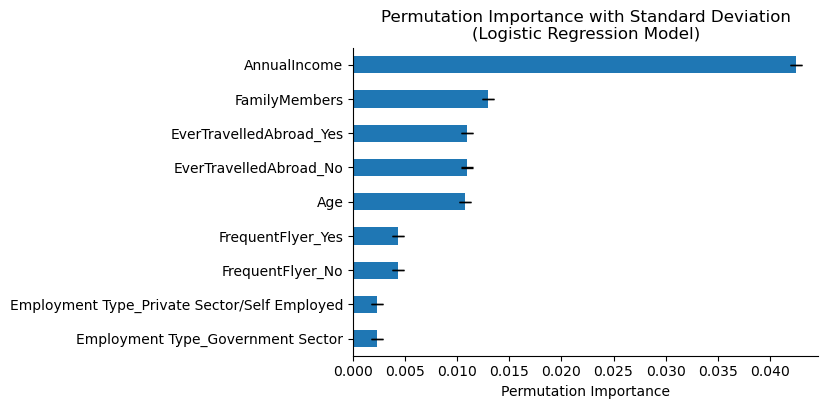

In [31]:
result = permutation_importance(logreg_best, X_train_scaled, y_train, n_repeats=50, random_state=99)

feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)


ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="tab:blue",
    figsize=(6, 4),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation\n(Logistic Regression Model)",
)
ax.legend([], frameon=False);

<h2 style="color:#045c6b">Decision Tree Classifier </h2>

Decision trees try to fit all of the data in the different leaves created. To limit the model and prevent overfitting, we are applying a max_depth and a minimum number of samples in a leaf. For interpretation purposes the tries with the depth were not set to values higher than 5, and the minumul samples not less than 15.

For this type of model scaling is irrelavant, so to facilitate its interpretation we will fit the model on the non-scaled training data.

In [32]:
param_grid = {
    'max_depth': [1, 2, 3, 5],  
    'min_samples_leaf': [15, 20, 50, 100]  
}

dtree = DecisionTreeClassifier(random_state=99)

# Create GridSearchCV instance with 5 folds
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best Parameters:",grid_search.best_params_)
print(f"Best Recall: {grid_search.best_score_:.3f}")

dtree_best = grid_search.best_estimator_

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 15}
Best Recall: 0.584


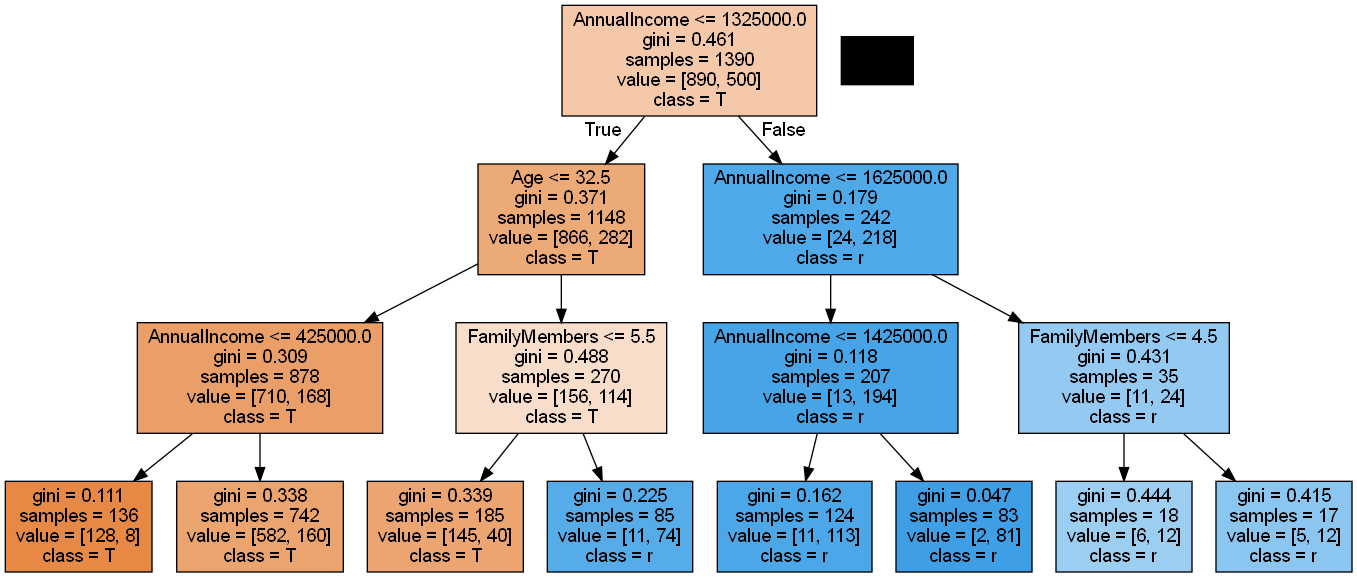

In [33]:
# Create DOT data
dot_data = export_graphviz(dtree_best,
                           out_file=None,
                           feature_names=X.columns,
                           class_names=y.name,
                           filled = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

This decision tree highlights the importance of the Annual Income for a client to buy or not a travel insurance. The importance is followed by the Age and the number of Family members. 

According to the predicted in this tree all of the binary variables don't have a major importance for the model.

In [34]:
# Evaluate the training
yhat_train = dtree_best.predict(X_train)
report = classification_report(y_train, yhat_train, target_names=["No", "Yes"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          No       0.80      0.96      0.88       890
         Yes       0.89      0.58      0.71       500

    accuracy                           0.83      1390
   macro avg       0.85      0.77      0.79      1390
weighted avg       0.84      0.83      0.81      1390



Similarly to the logistic model, this decision tree is better at describing clients who did not buy travel insurances (96%).

The recall for our target class was however not as good (58%).

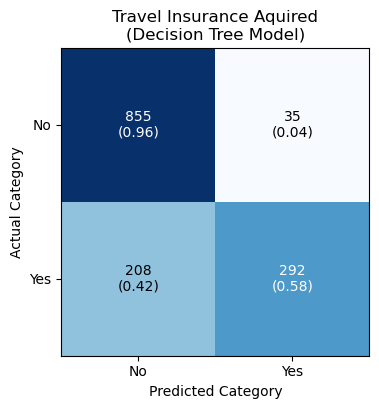

In [35]:
cm = metrics.confusion_matrix(y_train, yhat_train)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                figsize=(4, 4))

plt.xticks(np.arange(2), ["No", "Yes"])
plt.yticks(np.arange(2), ["No", "Yes"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Travel Insurance Aquired\n(Decision Tree Model)",);

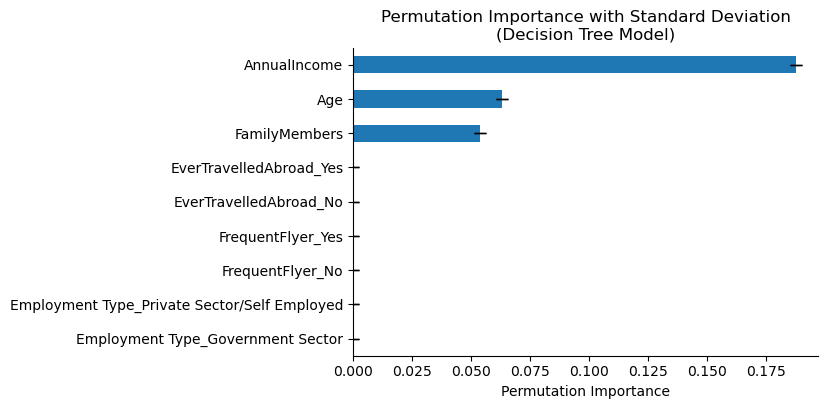

In [36]:
result = permutation_importance(dtree_best, X_train, y_train, n_repeats=50, random_state=99)

feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)


ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="tab:blue",
    figsize=(6, 4),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation\n(Decision Tree Model)",
)
ax.legend([], frameon=False);

<h2 style="color:#045c6b">Random Forest Classifier </h2>

Random Forest evaluate different decision trees. The number of estimators is the number of decision trees in the random forest.

In [37]:
param_grid = {
    "n_estimators": [10, 20, 30, 40],
    'max_depth': [1, 2, 3, 5],  
    'min_samples_leaf': [15, 20, 50, 100]  
}

rf = DecisionTreeClassifier(random_state=99)

# Create GridSearchCV instance with 5 folds
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best Parameters:",grid_search.best_params_)
print(f"Best Recall: {grid_search.best_score_:.3f}")

rf_best = grid_search.best_estimator_

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 10}
Best Recall: 0.572


In [38]:
# Evaluate the training
yhat_train = rf_best.predict(X_train)
report = classification_report(y_train, yhat_train, target_names=["No", "Yes"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          No       0.78      0.97      0.86       890
         Yes       0.89      0.51      0.65       500

    accuracy                           0.80      1390
   macro avg       0.84      0.74      0.75      1390
weighted avg       0.82      0.80      0.78      1390



Our random forest model presented the same results as the decision tree and have the disadvantage that we cannot see what is really under the hood. No need to present further details for this model.

<h2 style="color:#045c6b">Chosen Model - KNN</h2>

After evaluation of the models, the best accuracy was already obtained with our baseline model (KNN). 

As mentioned before, we will try to run this model again with the previously engineered feature to compare the results.

<h3 style="color:#045c6b">with Annual Income per Family Member</h3>

In [39]:
# Drop Columns
travel_insur_clean = travel_insur.drop(["GraduateOrNot", "ChronicDiseases", "AnnualIncome", "FamilyMembers"], axis=1)

# Encoder of features
features = ["Employment Type", "FrequentFlyer", "EverTravelledAbroad"]
one_hot_encoded_df = pd.get_dummies(travel_insur_clean[features])

# Merge and remove original features
encoded_travel_insur_clean = pd.concat(
    [travel_insur_clean, one_hot_encoded_df], axis=1
).drop(features, axis=1)

encoded_travel_insur_clean.head(2)

,Age,TravelInsurance,Income_FamilyMembers,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,31,0,66666.667,1,0,1,0,1,0
1,31,0,178571.429,0,1,1,0,1,0


In [40]:
# Separate dependent variable
X_Income_Fam = encoded_travel_insur_clean.drop("TravelInsurance", axis=1)
y_Income_Fam = encoded_travel_insur_clean["TravelInsurance"]

# Separate train and test data
(
    X_train_Income_Fam,
    X_test_Income_Fam,
    y_train_Income_Fam,
    y_test_Income_Fam,
) = train_test_split(X_Income_Fam, y_Income_Fam, test_size=0.3, random_state=99)

scaler = StandardScaler()
X_train_scaled_Income_Fam = scaler.fit_transform(X_train_Income_Fam)

X_test_scaled_Income_Fam = scaler.transform(X_test_Income_Fam)

In [41]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

# Create GridSearchCV instance with 5 folds
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled_Income_Fam, y_train_Income_Fam)

print("Best Parameters:",grid_search.best_params_)
print(f"Best Recall: {grid_search.best_score_:.3f}")

knn_best_Income_Fam = grid_search.best_estimator_

Best Parameters: {'n_neighbors': 3, 'p': 1}
Best Recall: 0.582


In [42]:
# Evaluate the training
yhat_train_Income_Fam = knn_best_Income_Fam.predict(X_train_scaled_Income_Fam)
report = classification_report(y_train_Income_Fam, yhat_train_Income_Fam, target_names=["No", "Yes"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.91      0.87       890
         Yes       0.81      0.70      0.75       500

    accuracy                           0.83      1390
   macro avg       0.83      0.80      0.81      1390
weighted avg       0.83      0.83      0.83      1390



**The model with the engineered feature had a drop from 77% to 75% in recall** and from 85% to 83% in accuracy.

<h3 style="color:#045c6b">Test data</h3>

Let's test the model and evaluate it again.

In [43]:
# Evaluate for the test set
yhat_test = knn_best.predict(X_test_scaled)
report = classification_report(y_test, yhat_test, target_names=["No", "Yes"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          No       0.80      0.87      0.83       387
         Yes       0.70      0.59      0.64       210

    accuracy                           0.77       597
   macro avg       0.75      0.73      0.74       597
weighted avg       0.76      0.77      0.76       597



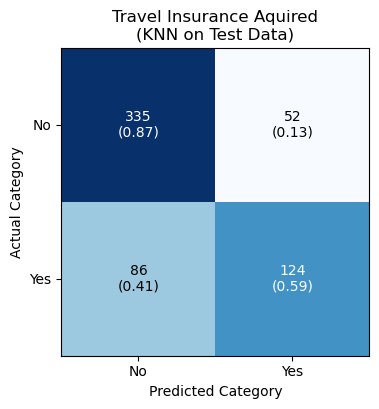

In [44]:
cm = metrics.confusion_matrix(y_test, yhat_test)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                figsize=(4, 4))

plt.xticks(np.arange(2), ["No", "Yes"])
plt.yticks(np.arange(2), ["No", "Yes"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Travel Insurance Aquired\n(KNN on Test Data)",);

Our final model predicted **59% of potential clients with new data**, which is a level of recall that **I not would consider enough to implement the model**.

The general accuracy of the model is about 77%.

<h1 style="color:#045c6b">Conclusion </h1>

By analyzing customer data and the purchases of travel insurance in the year 2019, the model can identify potential buyers. This assists the travel insurance company in **optimizing their marketing strategy, improving customer engagement, and boosting travel insurance purchases**.

In this model tries the implementation of One Hot Encoder did not change the output of the models (in relation to just attributing 0s and 1s in the columns).


Points of improvement:
- Implementation of pipelines;